## Set up
### Importing libraries

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from itertools import combinations

### Data load & enrichment

In [2]:
data_folder = '.'

additional_features = pd.read_csv(f"{data_folder}/data.csv").drop("Id", axis=1)
additional_features = additional_features.fillna(additional_features.mean())
additional_features = additional_features.fillna('N/A')
base_features = pd.read_csv(f"{data_folder}/Houseprice_data_scaled.csv")
for c in base_features.columns:
    try:
        additional_features = additional_features.drop([c], axis=1)
    except KeyError:
        next

### Parameters & Constants

In [3]:
# Params
SHOW_CAT_TO_NUM_WARNING = False
ADDITIONAL_FEATURES_SELECT = ['MSSubClass', 'BsmtExposure']
LAMBDA_RIDGE = 0.16
LAMBDA_LASSO = 0.06
SEED = 56

# Constants
ADDITIONAL_FEATURES_FIXED = ['LotFrontage', 'LotShape']
ADDITIONAL_FEATURES = ADDITIONAL_FEATURES_FIXED + ADDITIONAL_FEATURES_SELECT
# Trying my damn best to natually map a categorical to numerical 
CAT_MAPS = {
    "LotShape": {
        "Reg": 3,
        "IR1": 2,
        "IR2": 1,
        "IR3": 0,
    },
    'MSZoning': {
        'A': 0,
        'I': 1,
        'FV': 2,
        'RH': 3,
        'RM': 4,
        'RL': 5,
        'RP': 6,
        'C': 7,
    },
    'Utilities': {
        'ELO': 0,
        'NoSeWa': 1,
        'NoSewr': 2,
        'AllPub': 3,
    },
    'LotConfig': {
        'Inside': 0,
        'Corner': 1,
        'CulDSac': 2,
        'FR2': 3,
        'FR3': 4,
    },
    'LandSlope': {
        'Gtl': 2,
        'Mod': 1,
        'Sev': 0,
    },
    'BldgType': {
        '1Fam': 4,
        '2FmCon': 3,
        'Duplx': 2,
        'TwnhsE': 1,
        'Twnhsl': 0,
    },
    'HouseStyle': {
        '1Story': 0,
        '1.5Unf': 1,
        '1.5Fin': 2,
        '2Story': 3,
        '2.5Unf': 4,
        '2.5Fin': 5,
        'SFoyer': 6,
        'SLvl': 7,
    },
    "ExterQual": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "ExterCond": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "BsmtQual": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "BsmtCond": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "BsmtExposure": {
        "Gd": 4,
        "Av": 3,
        "Mn": 2,
        "No": 1,
        "NA": 0,
    },
    "BsmtFinType1": {
        "GLQ": 6,
        "ALQ": 5,
        "BLQ": 4,
        "Rec": 3,
        "LwQ": 2,
        "Unf": 1,
        "NA": 0,
    },
    "BsmtFinType2": {
        "GLQ": 6,
        "ALQ": 5,
        "BLQ": 4,
        "Rec": 3,
        "LwQ": 2,
        "Unf": 1,
        "NA": 0,
    },
    "HeatingQC": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "Electrical": {
        "Sbrkr": 3,
        "FuseA": 2,
        "FuseF": 1,
        "FuseP": 0,
        "Mix": 1.5,
    },
    "KitchenQual": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "Functional": {
        "Min1": 6,
        "Min2": 5,
        "Mod": 4,
        "Maj1": 3,
        "Maj2": 2,
        "Sev": 1,
        "Sal": 0,
    },
    "FireplaceQu": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "GarageType": {
        "NA": 0,
        "Attchd": 1,
        "Basment": 2,
        "BuiltIn": 3,
        "Carport": 4,
        "Detchd": 5,
        "2Types": 2.5,
    },
    "GarageFinish": {
        "Fin": 3,
        "RFn": 2,
        "Unf": 1,
        "NA": 0,
    },
    "GarageQual": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "GarageCond": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "PavedDrive": {
        "Y": 2,
        "P": 1,
        "N": 0,
    },
    "PoolQC": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "NA": 0,
    },
    "Fence": {
        "GdPrv": 4,
        "GdWo": 3,
        "MnPrv": 2,
        "MnWw": 1,
        "NA": 0,
    },
}


### Helper functions

In [4]:
def add_features(base, feature_name):
    """ 
    Outputs a dataframe which equals base_features plus any feature_name from additional_features. 
    Any categorical features will be naively converts to numerical values. All the feature values will be scaled.
    Any missing values (N/A) are filled with average values for this feature
    """
    rep_base = base.copy()
    def add_single_feature(single_feature):
        if is_numeric_dtype(additional_features[single_feature].dtype):
            rep_base[single_feature] = additional_features[single_feature]
        else:
            f_list = np.setdiff1d(additional_features[single_feature].unique(), ['N/A'])
            try:
                f_map = CAT_MAPS[single_feature]
            except KeyError:
#                 print("Warning: Can't find defined feature mapping for {} and it is automatically mapped to numerical".format(single_feature))
                f_map = dict(zip(f_list, range(len(f_list))))
            if SHOW_CAT_TO_NUM_WARNING:
                print("Warning: feature {} is categorical. Mapping to numerical...".format(single_feature))
                print("Mapping: {}".format(f_map))    
            rep_base[single_feature] = additional_features[single_feature].map(f_map)
            # TODO: what to do for NA in categorical features?
            rep_base[single_feature] = rep_base[single_feature].replace('N/A', np.nan)
            rep_base[single_feature] = rep_base[single_feature].fillna(rep_base[single_feature].mean())
        rep_base[single_feature] = (rep_base[single_feature] - rep_base[single_feature].mean()) / rep_base[single_feature].std()
    if type(feature_name) == str:
        add_single_feature(feature_name)
    else:
        for f in feature_name:
            add_single_feature(f)
    return rep_base

def split_dataset(dataset, k_fold=False):
    """ 
    Split input dataset into training, validation and test set (in this order) of size 1800, 600 and whatever left.
    In case of cross validation, train/val will be lists
    """
    idx_lst = np.arange(len(dataset))
    # Should really get rid of all the magic numbers
    if k_fold:
        np.random.seed(SEED)
        np.random.shuffle(idx_lst)
        train_val_idx = idx_lst[:1800+600]
        test = dataset.iloc[idx_lst[1800+600:len(dataset)]]
        pods = []
        for i in range(4):
            pods.append(idx_lst[600*i:600*(i+1)])
        train = []
        val = []
        for i in range(4):
            val.append(dataset.iloc[pods[i]])
            train.append(dataset.iloc[np.concatenate([pods[j] for j in set(range(4)) - set([i])])])
    else:
        train = dataset.iloc[idx_lst[:1800]]
        val = dataset.iloc[idx_lst[1800:1800+600]]
        test = dataset.iloc[idx_lst[1800+600:len(dataset)]]
    return train, val, test

def split_xy(dataset, value_name="SalePrice"):
    """ Split input data set into feature and value """
    try:
        return dataset.drop(value_name, axis=1), dataset[[value_name]]
    except AttributeError:
        return [(d.drop(value_name, axis=1), d[[value_name]]) for d in dataset]

def regression(features, method='linear', alpha=0, cross_validation=None, cv_parameter=None):
    """ 
    Run a regression of choice with additional features added to base_features
    
    :param features: A list of features available in dataframe additional_features
    :param method: One of "linear", "ridge" or "lasso"
    :param alpha: Alpha pamameter used for ridge or lasso regression. Should be lambda in Hull's book times # of 
                  observations for ridge regression or half of lambda for lasso regression.
    :param random: Whether to split training/validation/test data sets randomly or not
    :param cross_validation: Method of cross validation. Only supports k-fold for now. If cross validation is used, output 
                             mse and coeffs are averaged results from cross validations
    :param cv_parameter: A tuple of numerical parameters used in cross validation. E.g. sample size p for training set in an
                         exhausive cross validation, or k in a k-fold.
    
    :return: A dictionary containing coeffients and model mse
    """
    # Select features
    df = add_features(base_features, list(features))
    
    # Split data set and split each into X and y where y is the price, and X is set of features
    train, val, test = [split_xy(x) for x in split_dataset(df, k_fold=(cross_validation == 'k-fold'))]
    
    # Fit model
    def fit_model(train_set, val_set, alpha):
        reg_model = {
            'linear': LinearRegression(),
            'ridge': Ridge(alpha=alpha),
            'lasso': Lasso(alpha=alpha),
        }[method.lower()]
        reg_model.fit(*train_set)
    
        return {
            'coeffs': pd.DataFrame(
                [
                    ['intercept'] + list(train_set[0]),
                    list(reg_model.intercept_) + list(reg_model.coef_ if method == 'lasso' else reg_model.coef_[0])
                ]
            ).transpose().set_index(0),
            'mse': mse(val_set[1], reg_model.predict(val_set[0])),
            'reg_model': reg_model,
            'test_set': test,
        }
    
    def with_cv(alpha):
        coeffs = []
        mses = []
        if cross_validation == 'k-fold':
            for i in range(len(train)):
                rs = fit_model(train[i], val[i], alpha)
                coeffs.append(rs['coeffs'])
                mses.append(rs['mse'])
            return {
                'coeffs': pd.DataFrame(pd.concat(coeffs, axis=1).mean(axis=1)),
                'mse': np.array(mses).mean(),
                'reg_model': rs['reg_model'],
                'test_set': test,
            }
        else:
            return fit_model(train, val, alpha)
    
    try:
        return with_cv(float(alpha))
    except TypeError:
        return [with_cv(float(a)) for a in alpha]


## Feature Selections
First, use lasso on all the feature, and only look at features that survived lasso.  
Then, for a fixed alpha level, select two features that minimizes mse using either linear, ridge or lasso regression  
Using ridge below since ridge in general gives a lower MSE than lasso  

We can see that a few important features popped out, e.g.
* BsmtExposure
* MSSubClass
* ExterQual

We will use *BsmtExposure* and *MSSubClass* together with *LotShape* and *LotFrontage* as additional features

In [5]:
# Assumes all the features are added. Look at what are the non zero features after lasso
tmp = regression(list(set(additional_features.columns) - set(['Sale Price'])), method='lasso', alpha=LAMBDA_LASSO/2)['coeffs']
ok_features = []
for i in tmp[abs(tmp[1]) > 0.01].index:
    if i in additional_features.columns:
        ok_features.append(i)

# Use Ridge regression to look at mse and select feature pairs
fdf = {
    'feature 1': [],
    'feature 2': [],
    'mse': [],
}
for feature_pair in list(combinations(set(additional_features.columns) - set(['SalePrice']), 2)):
    fdf['feature 1'].append(feature_pair[0])
    fdf['feature 2'].append(feature_pair[1])
    fdf['mse'].append(regression(feature_pair, method='ridge', alpha=LAMBDA_RIDGE*1800)['mse'])
fdf = pd.DataFrame(fdf)

# Compare back to ok_features. Really any good feature_pair shoulnd't of been dropped by lasso
tmp = []
for i in fdf.iterrows():
    if i[1]['feature 1'] in ok_features and i[1]['feature 2'] in ok_features:
        tmp.append(i[1])
pd.DataFrame(tmp).sort_values(by='mse')

,feature 1,feature 2,mse
3,MSSubClass,BsmtExposure,0.103085
6,MSSubClass,ExterQual,0.104897
220,BsmtExposure,ExterQual,0.105873
43,MSSubClass,MasVnrArea,0.107445
407,ExterQual,MasVnrArea,0.108068
41,MSSubClass,KitchenQual,0.108587
257,BsmtExposure,MasVnrArea,0.108783
22,MSSubClass,GarageFinish,0.109023
255,BsmtExposure,KitchenQual,0.109122
386,ExterQual,GarageFinish,0.109272


## Regression Analysis I

Use first 1800 as training set, next 800 as validation set and the rest as test set  

### Linear Regression

In [11]:
rs_lr_1 = regression(ADDITIONAL_FEATURES, method='linear')
print(f"MSE on validation set for linear regression: {rs_lr_1['mse']}")
rs_lr_1['coeffs']

MSE on validation set for linear regression: 0.09963289128468081


,1
0,
intercept,-0.0130533
LotArea,0.0548767
OverallQual,0.201808
OverallCond,0.0862793
YearBuilt,0.149683
YearRemodAdd,0.0264391
BsmtFinSF1,0.100529
BsmtUnfSF,-0.0177878
TotalBsmtSF,0.106896


### Ridge Regression

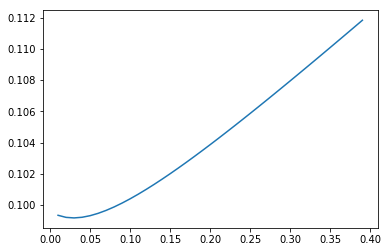

,1
0,
intercept,-0.0129029
LotArea,0.0470686
OverallQual,0.177341
OverallCond,0.0623393
YearBuilt,0.0857532
YearRemodAdd,0.0511777
BsmtFinSF1,0.0974717
BsmtUnfSF,-0.00991339
TotalBsmtSF,0.092521


In [7]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas * 1800

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='ridge', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800)['coeffs']

### Lasso Regression

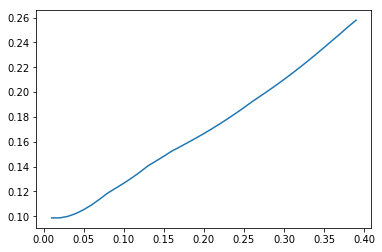

,1
0,
intercept,-0.0120813
LotArea,0.0412345
OverallQual,0.267005
OverallCond,0.0199697
YearBuilt,0.0769607
YearRemodAdd,0.057967
BsmtFinSF1,0.111117
BsmtUnfSF,-0
TotalBsmtSF,0.0893976


In [8]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas / 2

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='lasso', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='lasso', alpha=LAMBDA_LASSO/2)['coeffs']


### Use Ridge Regression on Test set

$\lambda$ set to 0.16

In [9]:
rs_1 = regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800)
coeffs_1 = rs_1['coeffs']
mse_1 = mse(rs_1['test_set'][1], rs_1['reg_model'].predict(rs_1['test_set'][0]))

print(f"MSE on test set: {mse_1}")
coeffs_1

MSE on test set: 0.10801029262011846


,1
0,
intercept,-0.0129029
LotArea,0.0470686
OverallQual,0.177341
OverallCond,0.0623393
YearBuilt,0.0857532
YearRemodAdd,0.0511777
BsmtFinSF1,0.0974717
BsmtUnfSF,-0.00991339
TotalBsmtSF,0.092521


## Regression Analysis II

Randomly determine training set, validation set and test set  
Perform k-fold cross-validatoin and take the average for MSE and coefficients. In this case we will use $k=4$ since we have set validation set to have 600 records and training set + validation set has 2400 records. 

### Linear Regression

In [13]:
rs_lr_2 = regression(ADDITIONAL_FEATURES, method='linear', cross_validation='k-fold')
print(f"MSE on validation set for linear regression: {rs_lr_2['mse']}")
rs_lr_2['coeffs']

MSE on validation set for linear regression: 0.10311545082619729


,0
0,
intercept,3.324712e-04
LotArea,4.629787e-02
OverallQual,2.070475e-01
OverallCond,8.473523e-02
YearBuilt,1.470830e-01
YearRemodAdd,3.316549e-02
BsmtFinSF1,8.470251e-02
BsmtUnfSF,-3.813528e-02
TotalBsmtSF,1.299848e-01


### Ridge Regression

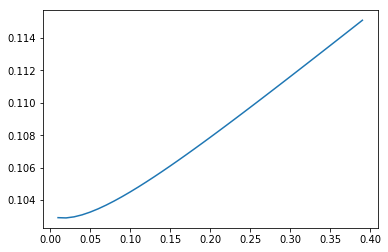

,0
0,
intercept,0.000515
LotArea,0.038732
OverallQual,0.179708
OverallCond,0.062948
YearBuilt,0.085403
YearRemodAdd,0.055042
BsmtFinSF1,0.095055
BsmtUnfSF,-0.014743
TotalBsmtSF,0.099670


In [14]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas * 1800

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='ridge', alpha=alphas, cross_validation='k-fold')]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800, cross_validation='k-fold')['coeffs']

### Lasso Regression

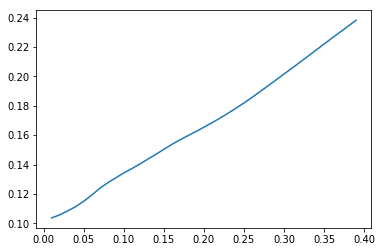

,0
0,
intercept,0.000629
LotArea,0.025811
OverallQual,0.273551
OverallCond,0.018129
YearBuilt,0.066908
YearRemodAdd,0.059433
BsmtFinSF1,0.109248
BsmtUnfSF,-0.000000
TotalBsmtSF,0.083823


In [15]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas / 2

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='lasso', alpha=alphas, cross_validation='k-fold')]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='lasso', alpha=LAMBDA_LASSO/2, cross_validation='k-fold')['coeffs']

### Use Ridge Regression on Test set

$\lambda$ set to 0.16

In [16]:
rs_2 = regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800, cross_validation='k-fold')
coeffs_2 = rs_2['coeffs']
mse_2 = mse(rs_2['test_set'][1], rs_2['reg_model'].predict(rs_2['test_set'][0]))

print(f"MSE on test set: {mse_2}")
coeffs_2

MSE on test set: 0.10882639849241203


,0
0,
intercept,0.000515
LotArea,0.038732
OverallQual,0.179708
OverallCond,0.062948
YearBuilt,0.085403
YearRemodAdd,0.055042
BsmtFinSF1,0.095055
BsmtUnfSF,-0.014743
TotalBsmtSF,0.099670


## Observations
A good observation is that as lambda level increases, the average magnitude of coefficients decreases in ridge and lasso regression

Average magnitude of coefficients vs lambda level

Ridge Regression


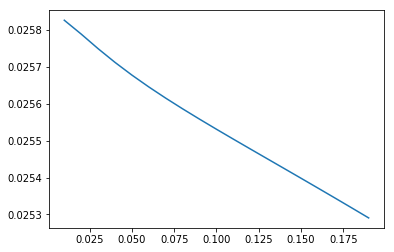

Lasso Regression


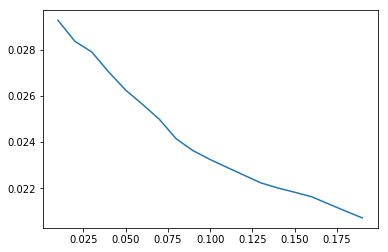

In [17]:
# Yvonne's for loop

lambdas = np.arange(0.01, 0.2, 0.01)
alphas = {'ridge': lambdas * 1800, 'lasso': lambdas / 2}

print("Average magnitude of coefficients vs lambda level\n")
for m in ['ridge', 'lasso']: 
    print(f'{m.capitalize()} Regression')
    plt.plot(lambdas, [float(shit['coeffs'].mean()) for shit in regression(ADDITIONAL_FEATURES, method=m, alpha=alphas[m])])
    plt.show()